## Task 2 train/val split EDA
The purpose of this notebook, is to explore the data to then determine a good enough method to split the data between training and validation sets.

In [1]:
import os
import yaml

import numpy as np
import matplotlib.pyplot as plt

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
def patches_distr_perc(patch: np.ndarray) -> dict:
    distr = {}
    patch_total_pixels = 128 * 128
    for i in range(patch.shape[0]):
        n_buildings = np.sum(patch[i])
        percentage_buildings = ((n_buildings / patch_total_pixels) * 100).round(2)
        if percentage_buildings not in distr:
            distr[percentage_buildings] = 0
        else:
            distr[percentage_buildings] += 1

    return distr

In [3]:
def group_by_interval(distr, interval, total_num_patches):
    intervals = {i * interval: 0 for i in range((100 // interval) + 1)}
    
    for key, value in distr.items():
        grouped_key = int(key // interval) * interval
        intervals[grouped_key] += value
    
    proportions = {k: (v / total_num_patches) for k, v in intervals.items()}
    return intervals, proportions

In [4]:
def plot_distr_bar(distr_grouped: dict, interval_percentage:int) -> None:
    x = list(distr_grouped.keys())
    y = list(distr_grouped.values())
    plt.bar(x, y)
    plt.xlabel(f'Percentage of buildings in the patch, by {interval_percentage}% intervals')
    plt.ylabel('Number of patches')
    plt.show()

In [5]:
def plot_distr_pie_chart(distr_grouped: dict, total_num_patches:int) -> None:
    distr_pie_chart = {k : ((v / total_num_patches) * 100) for k, v in distr_grouped.items()}
    # remove the keys that have 0 value
    distr_pie_chart = {k: v for k, v in distr_pie_chart.items() if v != 0}
    labels = list(distr_pie_chart.keys())
    sizes = list(distr_pie_chart.values())
    fig1, ax1 = plt.subplots()
    fig1.set_size_inches(10, 10)
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
    plt.show()

In [6]:
def stats_buildings(patch: np.ndarray, patch_total_pixels:int) -> tuple:
    n_buildings = []
    for i in range(patch.shape[0]):
        n_buildings.append(np.sum(patch[i]))
    n_buildings = np.array(n_buildings)
    mean_n_buildings = np.mean(n_buildings)
    median_n_buildings = np.median(n_buildings)
    mean_percentage_buildings = ((mean_n_buildings / patch_total_pixels) * 100).round(2)
    return mean_n_buildings, median_n_buildings, mean_percentage_buildings


Patch side size: 32
Mean number of buildings by 32x32 patch: 219.89754444621505
Median number of buildings by 32x32: 109.0
Mean percentage of buildings by 32x32: 21.47
----------------------------------


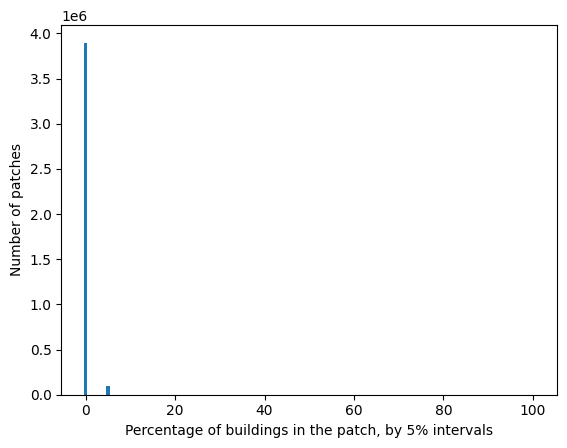

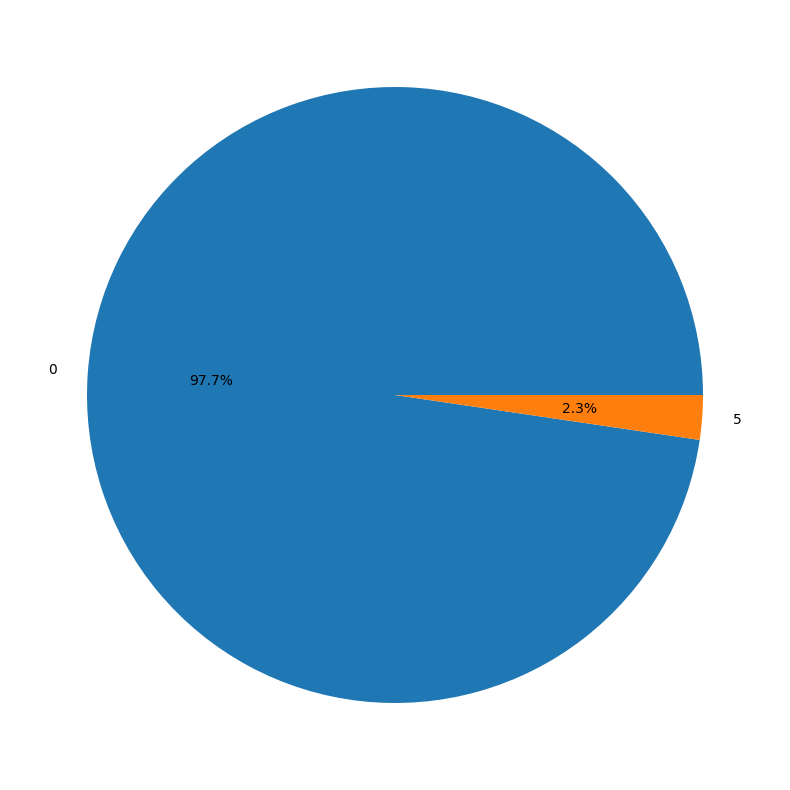


Patch side size: 64
Mean number of buildings by 64x64 patch: 875.8685782556751
Median number of buildings by 64x64: 561.0
Mean percentage of buildings by 64x64: 21.38
----------------------------------


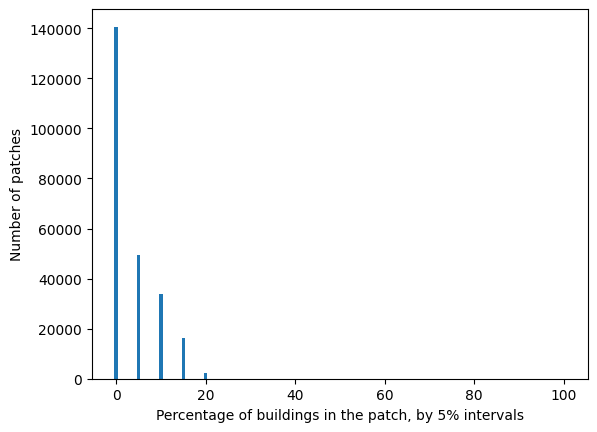

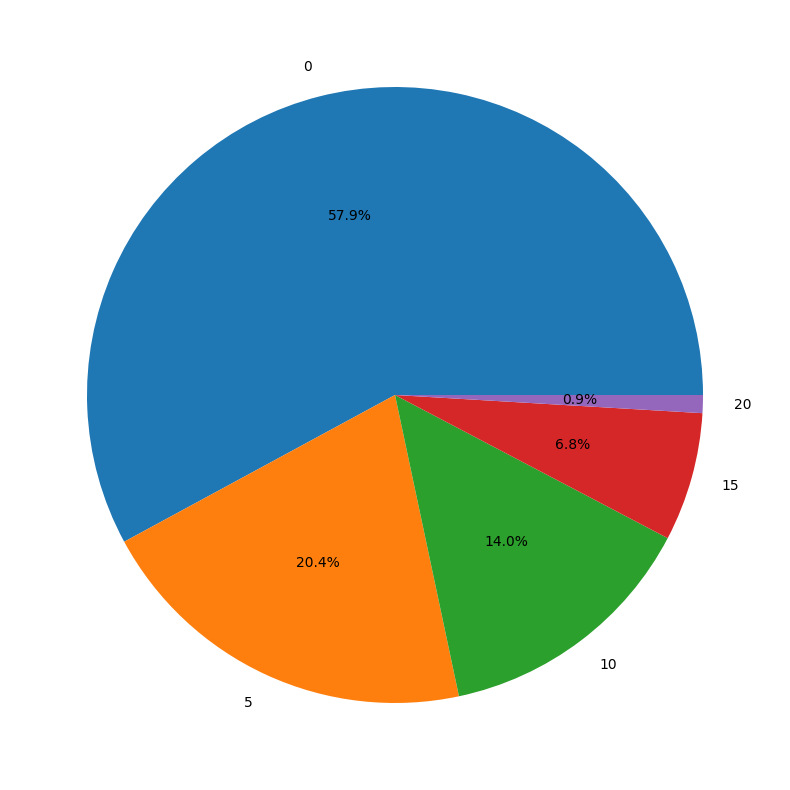


Patch side size: 128
Mean number of buildings by 128x128 patch: 3447.9140310233684
Median number of buildings by 128x128: 2559.0
Mean percentage of buildings by 128x128: 21.04
----------------------------------


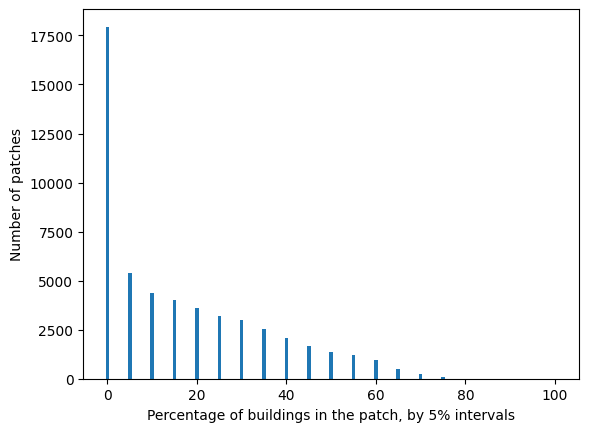

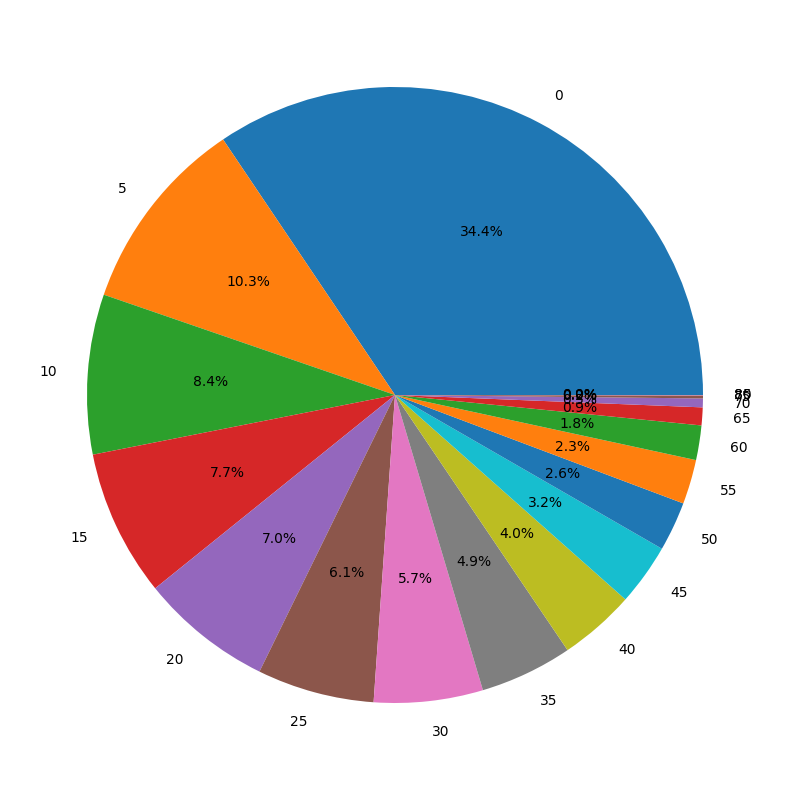

In [8]:
yml_file = f'{module_path}/config/data_pipeline.yml'
with open(yml_file, 'r') as file:
    data_pipeline_config = yaml.load(file, Loader=yaml.FullLoader)

patches_save_dir = data_pipeline_config['patches_save_dir']
patch_side_sizes = [patch['size'] for patch in data_pipeline_config['patches']]
perc_group_interval = 5

for patch_side_size in patch_side_sizes:
    patch_total_pixels = patch_side_size * patch_side_size
    patch = np.load(f'{module_path}/{patches_save_dir}/buildings_{patch_side_size}.npy')
    total_num_patches = patch.shape[0]
    mean_n_buildings, median_n_buildings, mean_percentage_buildings = stats_buildings(patch, patch_total_pixels)
    print(f'Patch side size: {patch_side_size}')
    print(f'Mean number of buildings by {patch_side_size}x{patch_side_size} patch: {mean_n_buildings}')
    print(f'Median number of buildings by {patch_side_size}x{patch_side_size}: {median_n_buildings}')
    print(f'Mean percentage of buildings by {patch_side_size}x{patch_side_size}: {mean_percentage_buildings}')
    print('----------------------------------')
    distr = patches_distr_perc(patch)
    distr_grouped, proportions = group_by_interval(distr, perc_group_interval, total_num_patches)
    plot_distr_bar(distr_grouped, perc_group_interval)
    plot_distr_pie_chart(distr_grouped, total_num_patches)
    print()

## Conclusion
- When the patch is bigger, there is a higher chance that it will contain more buildings.
- Most pixels don't have a building (imbalance).

Therefore, it is important to account this, by assigning a somewhat same percentage of buildings pixels count for training and for validation sets.

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load the data
city_to_split = np.load('/home/asicoder/gitrepos/Sentinel-2A-Segmentation/data/city_128.npy')
buildings_to_split = np.load('/home/asicoder/gitrepos/Sentinel-2A-Segmentation/data/buildings_128.npy')
train_perc = 0.8

# Calculate the percentage of buildings in each patch
building_percentages = np.mean(buildings_to_split, axis=(1, 2))

# Bin the building percentages to create classes for stratification
num_bins = 10  # You can adjust the number of bins as needed
bins = np.linspace(0, 1, num_bins + 1)
binned_percentages = np.digitize(building_percentages, bins) - 1

# Perform stratified split based on binned percentages
train_indices, val_indices = train_test_split(
    np.arange(len(building_percentages)),
    train_size=train_perc,
    stratify=binned_percentages
)

# Split the arrays into train and validation sets
city_train = city_to_split[train_indices]
city_val = city_to_split[val_indices]
buildings_train = buildings_to_split[train_indices]
buildings_val = buildings_to_split[val_indices]

# Output the shape of the resulting arrays to verify the split
print("City train shape:", city_train.shape)
print("City validation shape:", city_val.shape)
print("Buildings train shape:", buildings_train.shape)
print("Buildings validation shape:", buildings_val.shape)

# Verify the distribution of buildings in each set
print("Buildings train percentage:", np.mean(buildings_train))
print("Buildings validation percentage:", np.mean(buildings_val))


City train shape: (47654, 13, 128, 128)
City validation shape: (11914, 13, 128, 128)
Buildings train shape: (47654, 128, 128)
Buildings validation shape: (11914, 128, 128)
Buildings train percentage: 0.2104808762385011
Buildings validation percentage: 0.21029635934155722
